# Conceptual overview of waiting times

**Active Processing** (Worker working) Service Time	
    
    Goal: A probability distribution (e.g., Normal, Exponential) assigned to the activity.

**Queueing** (Waiting for worker)	Waiting Time	
    
    Goal: This is not modeled via distribtuions. The simulation generates this dynamically based on resource scarcity.

**External Wait** (Waiting for User)	Intermediate 
    
    Goal: Should probably be modeled in the simulation, but not attributed to the processing time of the resource itself

In [ ]:
import pm4py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [3]:
log = pm4py.read_xes('./data/BPI Challenge 2017.xes/BPI Challenge 2017.xes', return_legacy_log_object=True)

c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\Users\Henri\OneDrive - Universität zu Köln\Dokumente\TUM\3. Semester\BPTM Seminar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:10<00:00, 444.39it/s] 


In [4]:
df = pm4py.convert_to_dataframe(log)

## View data

In [5]:
df.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.Action.value_counts()

Action
statechange    358940
Obtained       255387
Created        223608
Released       215402
Deleted        148930
Name: count, dtype: int64

In [7]:
df['lifecycle:transition'].value_counts()

lifecycle:transition
complete     475306
suspend      215402
schedule     149104
start        128227
resume       127160
ate_abort     85224
withdraw      21844
Name: count, dtype: int64

In [8]:
df['EventOrigin'].value_counts()

EventOrigin
Workflow       768823
Application    239595
Offer          193849
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Action                 1202267 non-null  object             
 1   org:resource           1202267 non-null  object             
 2   concept:name           1202267 non-null  object             
 3   EventOrigin            1202267 non-null  object             
 4   EventID                1202267 non-null  object             
 5   lifecycle:transition   1202267 non-null  object             
 6   time:timestamp         1202267 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          1202267 non-null  object             
 8   case:ApplicationType   1202267 non-null  object             
 9   case:concept:name      1202267 non-null  object             
 10  case:RequestedAmount   1202267 non-null  float64            
 11  FirstWithdrawalAmount  4

# Generate best fitting distributions

1. Clean dataset to fit current BPMN log
2. Sort dataset by case, then activity and then timestamp to yield time differences

In [ ]:
# load and preprocess data
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)


# 2. calculate processing times
df_sorted = df.sort_values(['case:concept:name', 'concept:name', 'time:timestamp']).copy()

# Calculate time difference between consecutive rows
df_sorted['delta_prev'] = df_sorted['time:timestamp'].diff().dt.total_seconds()

# Shift columns to compare current row with previous row
df_sorted['prev_lifecycle'] = df_sorted['lifecycle:transition'].shift(1)
df_sorted['prev_case'] = df_sorted['case:concept:name'].shift(1)
df_sorted['prev_activity'] = df_sorted['concept:name'].shift(1)


# clean dataframe to only contain actvitities in our simulated bmpn 
bpmn_activities = [
    'A_Create Application', 'A_Submitted', 'W_Complete application', 
    'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 
    'O_Sent (mail and online)', 'W_Call after offers', 'A_Cancelled', 
    'O_Cancelled', 'A_Complete', 'W_Validate application', 'O_Accepted', 
    'A_Validating', 'A_Pending', 'O_Returned', 'W_Handle leads', 'A_Denied'
]


df_sorted = df_sorted[df_sorted['concept:name'].isin(bpmn_activities)].copy()

--- Fitting for W_Complete application ---
  expon: p-value=0.0000
  norm: p-value=0.0000
  lognorm: p-value=0.8154


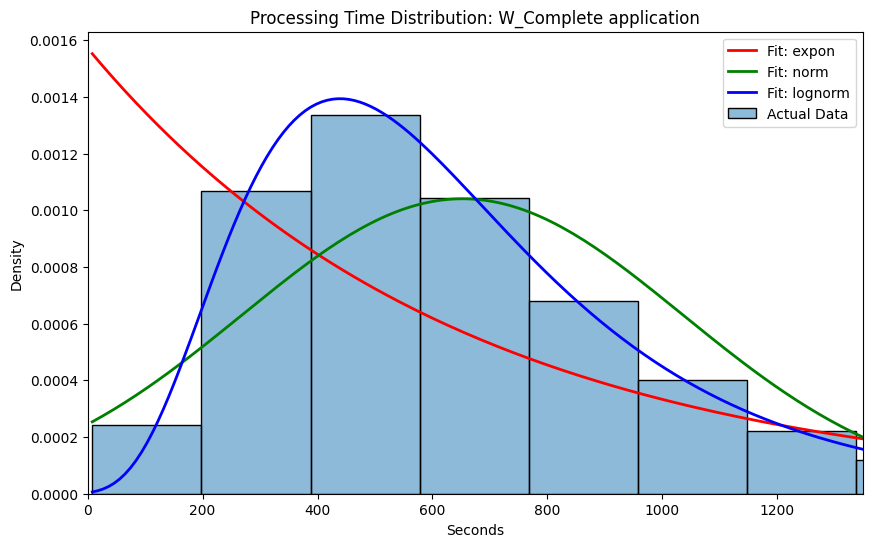

--- Fitting for W_Validate application ---
  expon: p-value=0.0000
  norm: p-value=0.0000
  lognorm: p-value=0.0000


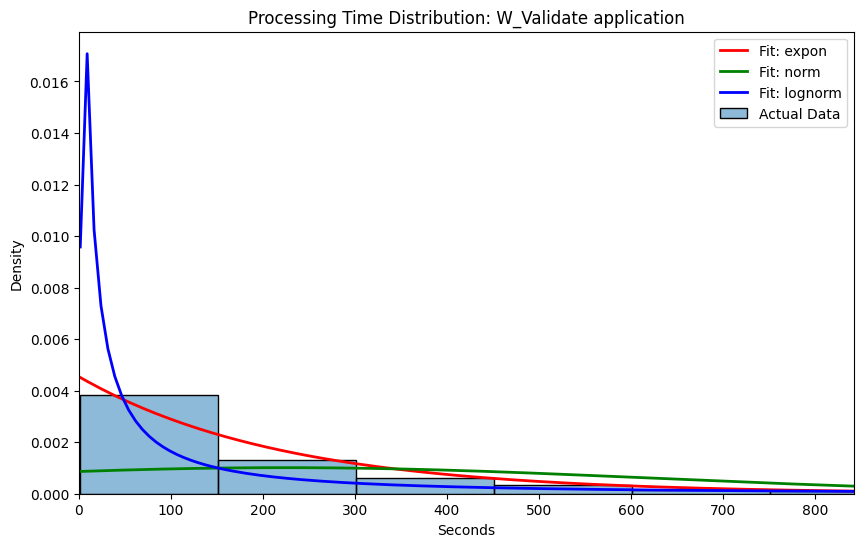

--- Fitting for W_Handle leads ---
  expon: p-value=0.0000
  norm: p-value=0.0000
  lognorm: p-value=0.1745


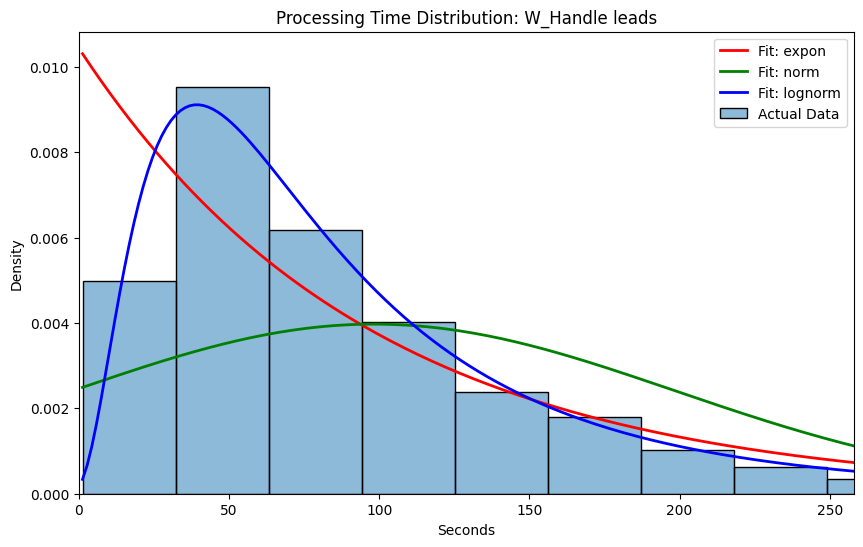

--- Fitting for W_Call after offers ---
  expon: p-value=0.0000
  norm: p-value=0.0000
  lognorm: p-value=0.0002


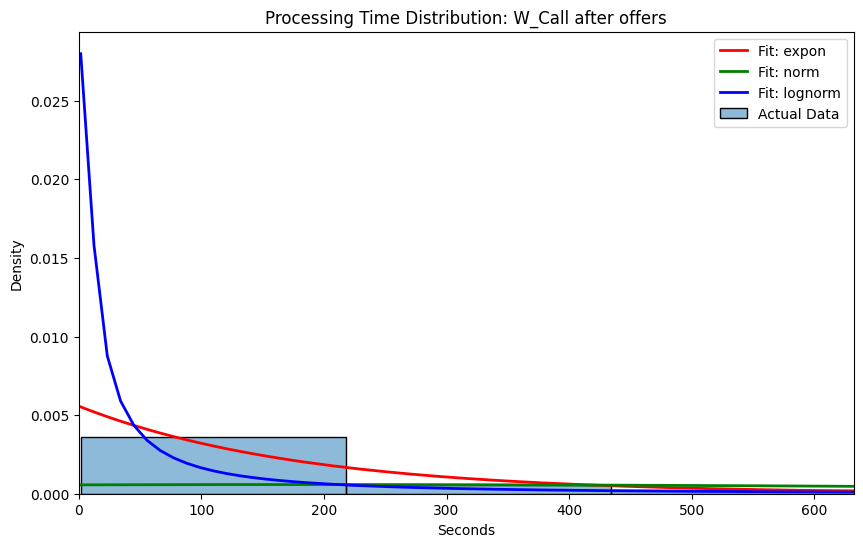

In [ ]:


# LOGIC:
# Duration is valid IF:
# 1. Current event is 'complete'
# 2. Previous event was 'start'
# 3. It's the same Case AND same Activity
mask_valid_duration = (
    (df_sorted['lifecycle:transition'] == 'complete') &
    (df_sorted['prev_lifecycle'] == 'start') &
    (df_sorted['case:concept:name'] == df_sorted['prev_case']) &
    (df_sorted['concept:name'] == df_sorted['prev_activity'])
)

# Apply mask
df_sorted.loc[mask_valid_duration, 'processing_time'] = df_sorted['delta_prev']

# Fill the rest with 0 (Instantaneous events like "A_Create Application")
df_sorted['processing_time'] = df_sorted['processing_time'].fillna(0)

# Create a clean dataframe of just the completions with their calculated times
activity_durations = df_sorted[df_sorted['lifecycle:transition'] == 'complete'][['concept:name', 'processing_time']].copy()

# Filter out 0 durations for the Distribution Plotting (Log-Normal crashes on 0)
# We only want to fit distributions to activities that actually take time (mostly W_ activities)
nonzero_durations = activity_durations[activity_durations['processing_time'] > 1].copy()

# 3. FIT DISTRIBUTIONS & PLOT
# List of distributions to test (as per assignment "Basic: fit on historical data")
dist_names = ['expon', 'norm', 'lognorm']

# Get list of activities that have valid durations
activities_to_plot = nonzero_durations['concept:name'].unique()

for activity in activities_to_plot:
    subset = nonzero_durations[nonzero_durations['concept:name'] == activity]
    data = subset['processing_time'].values
    
    # Skip if too few data points
    if len(data) < 50:
        continue

    plt.figure(figsize=(10, 6))
    
    # A. Plot Histogram of Actual Data
    sns.histplot(data, stat="density", bins=50, alpha=0.5, label="Actual Data", kde=False)
    
    # B. Fit and Plot Distributions
    x_domain = np.linspace(min(data), max(data), 1000)
    
    best_dist = ""
    best_p_value = 0
    
    colors = {'expon': 'red', 'norm': 'green', 'lognorm': 'blue'}
    
    print(f"--- Fitting for {activity} ---")
    
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        
        # Fit the distribution to the data
        params = dist.fit(data)
        
        # Calculate the PDF (Probability Density Function) line
        pdf_y = dist.pdf(x_domain, *params)
        
        # Plot the line
        plt.plot(x_domain, pdf_y, color=colors[dist_name], lw=2, label=f'Fit: {dist_name}')
        
        # Optional: Perform KS-Test to see how "good" the fit is
        # (D statistic: lower is better; p-value: higher is better match)
        D, p_value = stats.kstest(data, dist_name, args=params)
        print(f"  {dist_name}: p-value={p_value:.4f}")

    plt.title(f"Processing Time Distribution: {activity}")
    plt.xlabel("Seconds")
    plt.legend()
    plt.xlim(0, np.percentile(data, 95)) # Trim extreme outliers for visibility
    plt.show()

# Build prediction model for execution times of Workflow activities

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

In [91]:
durations = df_sorted[df_sorted['lifecycle:transition'] == 'complete'].copy()
durations = durations[durations['processing_time'] > 1]

### Feature engineering

In [ ]:
durations.info

<class 'pandas.core.frame.DataFrame'>
Index: 20280 entries, 445750 to 373686
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Action                 20280 non-null  object             
 1   org:resource           20280 non-null  object             
 2   concept:name           20280 non-null  object             
 3   EventOrigin            20280 non-null  object             
 4   EventID                20280 non-null  object             
 5   lifecycle:transition   20280 non-null  object             
 6   time:timestamp         20280 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          20280 non-null  object             
 8   case:ApplicationType   20280 non-null  object             
 9   case:concept:name      20280 non-null  object             
 10  case:RequestedAmount   20280 non-null  float64            
 11  FirstWithdrawalAmount  0 non-null      float64       

In [100]:
durations.columns

Index(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'OfferID', 'delta_prev',
       'prev_lifecycle', 'prev_case', 'prev_activity', 'processing_time',
       'dow', 'month', 'hour', 'resource_category'],
      dtype='object')

In [93]:
len(durations['org:resource'].unique())

142

In [139]:
durations['time:timestamp'] = pd.to_datetime(durations['time:timestamp'])

# Create new numeric features from the timestamp
durations['dow'] = durations['time:timestamp'].dt.dayofweek    # Monday=0, Sunday=6
durations['month'] = durations['time:timestamp'].dt.month
durations['hour'] = durations['time:timestamp'].dt.hour

# create abstract feature on what resource is handling the case (here grouped by cases handled)
# Calculate counts for every resource
resource_counts = durations['org:resource'].value_counts()

# Identify the groups
top_1_resource = resource_counts.index[0]            # The single busiest person
high_vol_resources = resource_counts.index[1:10]     # Rank 2 to 10
mid_vol_resources = resource_counts.index[10:30]     # Rank 11 to 30
# Everyone else is implicitly "Low Volume"

# Define a function to categorize resources
def categorize_resource(res_name):
    if res_name == top_1_resource:
        return 'Top Resource'
    elif res_name in high_vol_resources:
        return 'High Volume'
    elif res_name in mid_vol_resources:
        return 'Medium Volume'
    else:
        return 'Low Volume'

# Apply the function to create a new column
durations['resource_category'] = durations['org:resource'].apply(categorize_resource)

# Apply the function to create a new column
durations['resource_category'] = durations['org:resource'].apply(categorize_resource)

# 3. Data Cleaning
# Handle NaN in 'prev_activity' (likely the first event of a case)
durations['prev_activity'] = durations['prev_activity'].fillna('Start')



# 2. Select Features (Independent Variables) & Target
features = [
    'concept:name',          # Current Activity
    'case:ApplicationType',  # Context
    'prev_activity',         # Sequence Context
    'dow',                   # Time Context
    'month',                 # Seasonal Context
    'hour',                   # Daily Context
    'resource_category',
    'case:RequestedAmount',
    'case:ApplicationType'
]


### Train test split

In [140]:
# Create X (Features) and y (Target)
X = durations[features].copy()
y = durations['processing_time']

# 4. Encoding Categorical Variables
# One-Hot Encoding converts strings to binary columns (0s and 1s)
X_encoded = pd.get_dummies(X, columns=['concept:name', 'case:ApplicationType', 'prev_activity', 'case:ApplicationType', 'resource_category'])

# 5. Train/Test Split
# Split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [141]:
X_train.head()

,dow,month,hour,case:RequestedAmount,concept:name_W_Call after offers,concept:name_W_Complete application,concept:name_W_Handle leads,concept:name_W_Validate application,case:ApplicationType_Limit raise,case:ApplicationType_New credit,...,prev_activity_W_Handle leads,prev_activity_W_Validate application,case:ApplicationType_Limit raise,case:ApplicationType_New credit,case:ApplicationType_Limit raise,case:ApplicationType_New credit,resource_category_High Volume,resource_category_Low Volume,resource_category_Medium Volume,resource_category_Top Resource
128263,5,2,11,10000.0,False,True,False,False,False,True,...,False,False,False,True,False,True,False,True,False,False
861661,3,10,15,15000.0,False,False,False,True,False,True,...,False,True,False,True,False,True,False,True,False,False
876036,0,9,6,10000.0,False,False,True,False,False,True,...,True,False,False,True,False,True,True,False,False,False
441810,2,6,11,20500.0,False,True,False,False,False,True,...,False,False,False,True,False,True,False,False,True,False
1102890,1,11,16,15000.0,False,True,False,False,False,True,...,False,False,False,True,False,True,False,True,False,False


### Train model

In [148]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) 
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Evaluate model

--- Model Performance ---
Mean Absolute Error: 235.87 seconds
R² Score: 0.3022


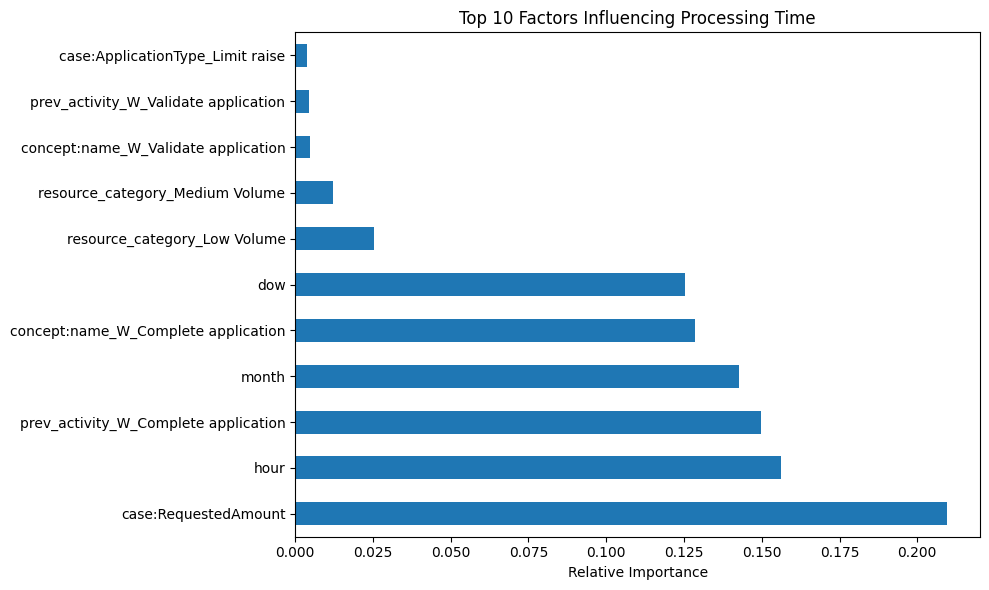

In [149]:
# 7. Evaluate
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("--- Model Performance ---")
print(f"Mean Absolute Error: {mae:.2f} seconds")
print(f"R² Score: {r2:.4f}")

# 8. Visualizing Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X_encoded.columns)

plt.figure(figsize=(10, 6))
feature_importances.nlargest(11).plot(kind='barh')
plt.title('Top 10 Factors Influencing Processing Time')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [144]:
print(X_test.iloc[4])
print(y_test.iloc[4])

dow                                          0
month                                        7
hour                                         8
case:RequestedAmount                    7000.0
concept:name_W_Call after offers         False
concept:name_W_Complete application       True
concept:name_W_Handle leads              False
concept:name_W_Validate application      False
case:ApplicationType_Limit raise         False
case:ApplicationType_New credit           True
case:ApplicationType_Limit raise         False
case:ApplicationType_New credit           True
prev_activity_W_Call after offers        False
prev_activity_W_Complete application      True
prev_activity_W_Handle leads             False
prev_activity_W_Validate application     False
case:ApplicationType_Limit raise         False
case:ApplicationType_New credit           True
case:ApplicationType_Limit raise         False
case:ApplicationType_New credit           True
resource_category_High Volume            False
resource_cate

In [145]:
row = X_test.iloc[[2]]
model.predict(row)

array([652.06095557])

### Save model for use in simulation engine

In [153]:
# Create the folder if it doesn't exist
folder_path = 'models'

# Save the trained model
model_filename = os.path.join(folder_path, 'rf_execution_time.pkl')
joblib.dump(model, model_filename)

# Save the column names
columns_filename = os.path.join(folder_path, 'rf_execution_time_columns.pkl')
model_columns = list(X_train.columns)
joblib.dump(model_columns, columns_filename)

print(f"Successfully saved model to: {model_filename}")
print(f"Successfully saved columns to: {columns_filename}")

Successfully saved model to: models\rf_execution_time.pkl
Successfully saved columns to: models\rf_execution_time_columns.pkl


In [ ]:
# Analyze waiting times in comparison to processing times

# Analyze waiting times in comparison to processing times

In [38]:
# 1. SETUP
# Load log and filter by BPMN activities (using the list we made previously)
bpmn_activities = [
    'A_Create Application', 'A_Submitted', 'W_Complete application', 
    'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 
    'O_Sent (mail and online)', 'W_Call after offers', 'A_Cancelled', 
    'O_Cancelled', 'A_Complete', 'W_Validate application', 'O_Accepted', 
    'A_Validating', 'A_Pending', 'O_Returned', 'W_Handle leads', 'A_Denied'
]


df_clean = df_sorted[df_sorted['concept:name'].isin(bpmn_activities)].copy()

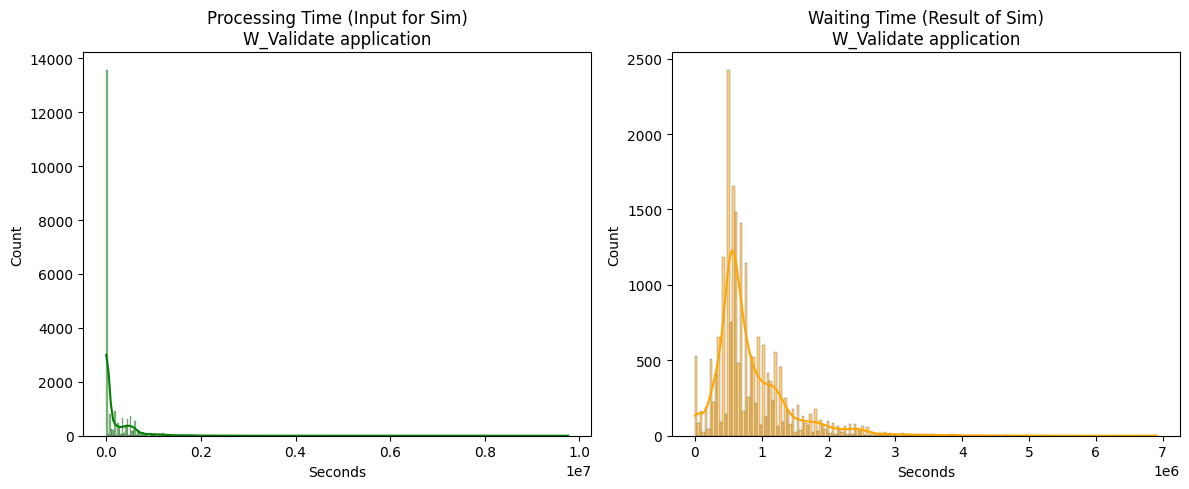

Stats for W_Validate application:
Avg Processing Time: 3375.11 mins
Avg Waiting Time:    229.89 hours


In [ ]:
# Sort strictly by Case and Time
df_clean = df_clean.sort_values(['case:concept:name', 'time:timestamp'])

# 2. CALCULATE PROCESSING TIME (Active Work)

# We focus on the W_ activities which have Start/Complete
# (For A_ and O_, processing time is 0)

# We define a "Task Instance" by grouping Case + Activity. 
# We take the MIN start and MAX complete to handle the lifecycle fragmentation simply.
# (This is a robust approximation for the "Basic" assignment)
task_groups = df_clean.groupby(['case:concept:name', 'concept:name'])

processing_data = []
for (case, activity), group in task_groups:
    starts = group[group['lifecycle:transition'] == 'start']['time:timestamp']
    completes = group[group['lifecycle:transition'] == 'complete']['time:timestamp']
    
    if not starts.empty and not completes.empty:
        # Duration = Last Complete - First Start (Simple approach)
        # OR use the "Segment Summation" code I gave you earlier for higher precision
        duration = (completes.max() - starts.min()).total_seconds()
        end_time = completes.max()
        start_time = starts.min()p
    else:
        # Instantaneous event (A_ or O_)
        duration = 0
        end_time = group['time:timestamp'].max()
        start_time = group['time:timestamp'].min()
        
    processing_data.append({
        'Case': case,
        'Activity': activity,
        'StartTime': start_time,
        'EndTime': end_time,
        'ProcessingTime': duration
    })

df_proc = pd.DataFrame(processing_data)
df_proc = df_proc.sort_values(['Case', 'StartTime'])


# 3. CALCULATE WAITING TIME (Queue)
# Waiting Time = Current Start - Previous End
df_proc['PrevEndTime'] = df_proc.groupby('Case')['EndTime'].shift(1)
df_proc['WaitingTime'] = (df_proc['StartTime'] - df_proc['PrevEndTime']).dt.total_seconds()

# Filter out negative waits (parallelism artifacts) and NaNs (first activity)
df_proc['WaitingTime'] = df_proc['WaitingTime'].fillna(0)
df_proc.loc[df_proc['WaitingTime'] < 0, 'WaitingTime'] = 0


# 4. VISUALIZE THE SPLIT
activity_name = "W_Validate application"
subset = df_proc[df_proc['Activity'] == activity_name]

if not subset.empty:
    plt.figure(figsize=(12, 5))
    
    # Plot Processing Time (Active Work)
    plt.subplot(1, 2, 1)
    sns.histplot(subset['ProcessingTime'], color='green', kde=True)
    plt.title(f"Processing Time (Input for Sim)\n{activity_name}")
    plt.xlabel("Seconds")
    
    # Plot Waiting Time (Queue)
    plt.subplot(1, 2, 2)
    sns.histplot(subset['WaitingTime'], color='orange', kde=True)
    plt.title(f"Waiting Time (Result of Sim)\n{activity_name}")
    plt.xlabel("Seconds")
    
    plt.tight_layout()
    plt.show()

    print(f"Stats for {activity_name}:")
    print(f"Avg Processing Time: {subset['ProcessingTime'].mean()/60:.2f} mins")
    print(f"Avg Waiting Time:    {subset['WaitingTime'].mean()/3600:.2f} hours")